<h1>Product Demand Prediction Model</h1>

<h2>Description</h2>

A model to predict the optimum inventory level of a product for the next week in the store based on previous sales history and other factors.

<h2>Dataset</h2>

The dataset is the transactional history of the store in question beginning from 01/01/2021 to 12/31/2022.
The columns Date, Scan Code, POS Retail, POS Cost, Quantity of item per transaction (Qty), and Department from this dataset will be used as features for the model. 


<h1>Cleaning up the data</h1>

- Remove any NAN values for scan code
- Remove any zero cost/ zero retail
- Fill In Missing Values if possible

In [1]:
import pandas as pd
import numpy as np
from utils.utils import getEmptyCells,collect_weekly_weather_data,collect_weekly_gas_avg
def clean_up(df):
    #remove all unidentified items except for gas and lotto online
    nan_scan_code = getEmptyCells(df,'Scan Code')
    for i in nan_scan_code:
        if df['Department'][i] == 'GAS PUMP #1' or df['Department'][i] == 'GAS PUMP #2' or df['Department'][i] == 'GAS PUMP #3' or df['Department'][i] == 'GAS PUMP #4':
            df.loc[df.index[i], 'Scan Code'] = '2235'
            df.loc[df.index[i], 'Department'] = 'GAS'
        elif df['Department'][i] == 'LOTTO ONLINE':
            df.loc[df.index[i], 'Scan Code'] = '2236'

    print("Before removing nan scan codes : ",df.shape)
    nan_scan_code = getEmptyCells(df,'Scan Code')

    #drop NaN scan codes
    df.drop(index=nan_scan_code,axis=0,inplace=True)
    print("After removing NaN scan codes : ",df.shape)
    df.drop(columns=['Register','Unnamed: 14'],inplace=True)
    df.reset_index(inplace = True)
    df.drop(columns=['index'],inplace=True)
    
    #remove other invalid scan codes
    invalid_scan_codes = df['Scan Code'].str.match("^[0-9]*$")
    invalid_indices = [i for i, x in enumerate(invalid_scan_codes) if x==False]
    df.drop(invalid_indices,axis=0,inplace=True)
    df.reset_index(inplace = True)
    df.drop(columns=['index'],inplace=True)
    
    #remove zero pos cost
    zero_cost = df[df['POS Cost'] < 0].index
    for i in zero_cost:
        if df['Department'][i] == 'GAS PUMP #1' or df['Department'][i] == 'GAS PUMP #2' or df['Department'][i] == 'GAS PUMP #3' or df['Department'][i] == 'GAS PUMP #4':
            df.loc[df.index[i], 'POS Cost'] = df['POS Retail'][i] -  (0.2 * df['POS Retail'][i]) # mean profit is 20%. Consulted with owner. Mean used because actual gas price were not recorded by the owner
        elif df['Department'][i] == 'LOTTO ONLINE' or df['Department'][i] == 'LOTTO SCRATCH OFF':
            df.loc[df.index[i], 'POS Cost'] = df['POS Retail'][i] -  (0.05 * df['POS Retail'][i]) 

    zero_cost = df[df['POS Cost'] < 0].index
    df.drop(index=zero_cost,axis=0,inplace=True)
    df.reset_index(inplace = True)
    df.drop(columns=['index'],inplace=True)
    print("After removing numm zero costs and negative : ",df.shape)
    
    #calculate discount amount to record if there was a sale on the product
    zero_retail = getEmptyCells(df,'Retail at Sale')
    df['Discounts'] = ''
    for i in zero_retail:
        df['Retail at Sale'][i] = df['POS Retail'][i]
    df['Discounts'] = df['Retail at Sale'] - df['POS Retail']
    
    #encode nominal values
    #df['Int Dept'] = pd.factorize(df['Department'])[0]
    #holiday data
    
    
    
    return df
    

{'code': '018200000089', 'codeType': 'UPC', 'product': {'name': 'Budweiser Beer, 32 Fl. Oz. Bottle', 'description': 'Known as "The King of Beers", Budweiser was first introduced by Adolphus Busch in 1876, and it\'s still brewed with the same high standards today. Budweiser is a medium-bodied, flavorful, crisp American-style lager. Brewed with the best barley malt and a blend of premium hop varieties, it is an iconic beer, celebrated in America. The King of Beers, crisp, refreshing American-style lager. Brewed in U.S.A. ABV: 5%. Pairs well with Pizza, Burgers, or Fried Chicken', 'region': 'USA or Canada', 'imageUrl': 'https://go-upc.s3.amazonaws.com/images/64152920.png', 'brand': 'Budweiser', 'specs': [], 'category': 'Beer', 'upc': 18200000089, 'ean': 18200000089}, 'barcodeUrl': 'https://go-upc.com/barcode/018200000089'}
-----------------------------------------------------------
{'code': '018200000164', 'codeType': 'UPC', 'product': {'name': 'Budweiser Beer - 6 Pack Cans', 'description

In [2]:
df = pd.read_csv('data/csv/original/sales2022.csv',dtype={'Scan Code':str})
df = clean_up(df)

Before removing nan scan codes :  (939929, 15)
After removing NaN scan codes :  (886560, 15)
After removing numm zero costs and negative :  (884917, 13)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [142]:
df.shape

(883819, 14)

In [151]:
df.drop(df[df['Qty'] < 0].index,axis = 0,inplace = True)

In [150]:
df.shape

(883819, 14)

<H1>Feature Generation</H1>

Since the model will be used to predict the inventory for the whole week, the above dataset is transformend into a weekly dataset.
Once we group the dataset in a weekly format the following features will be generated.
These generated features will be used as the predictor variable of the model.

<H2>Features </H2>

- Week Number specifing which week of the year
- Month of the year
- Average Retail Price of the item for the week
- Average Cost Price of the item for the week
- Department ID of the item
- Average Temperature of the week
- Average Regular Gasoline Retail Price of the week. This feature is included since the store provide gasoline   service and is one of the factor affecting the sales of other products. Historically, lower gas price has had       positive impact on customer traffic and hence increasing the likelyhood of product getting bought together with     gasoline.
- Total Sales of an Item per week

In [107]:
df['Date'] = pd.to_datetime(df['Date'])
weekly_df = df.groupby([pd.Grouper(key="Date", freq="7D",origin='2021-01-01'),'Scan Code','Description','Department']).agg({'Qty':'sum','POS Cost':'mean','POS Retail':'mean','Discounts':'mean'})
weekly_df.reset_index(inplace=True)
weekly_df['Month'] = weekly_df['Date'].dt.month
weekly_df['Week'] = weekly_df['Date'].dt.isocalendar().week
weekly_df['Year'] = weekly_df['Date'].dt.year

In [108]:
#weather data
from datetime import datetime
start = datetime(2021, 1, 1)
end = datetime(2022, 12, 31)
weekly_df['Avg Temp'] = ''
weekly_avg_temp = collect_weekly_weather_data(start,end,'2021-01-01','2022-12-31','2021-01-01')
weeks = list(weekly_avg_temp['date'])
temps = list(weekly_avg_temp['tavg']) 

#gas data
weekly_df['Avg Gas Price'] = ''
paths = ['data/csv/original/gas_21_22_cmb.csv']
weekly_gas_avg = collect_weekly_gas_avg(paths)
avg_price = list(weekly_gas_avg['Retail'])

week_counter = 0
for i in range(0,len(weeks)):
    dates = weekly_df[weekly_df['Date'] == weeks[i]].index
    weekly_df.loc[dates, 'Avg Temp'] = temps[i]
    weekly_df.loc[dates, 'Avg Gas Price'] = avg_price[i]


In [5]:
data_2021 = weekly_df[weekly_df['Year'] == 2021]
data_2022 = weekly_df[weekly_df['Year']== 2022]
prods_2021 = set(data_2021['Scan Code'].unique())
prods_2022 = set(data_2022['Scan Code'].unique())
relevant = list(prods_2022 & prods_2021)
irrelevant = list(prods_2021 - prods_2022)
irrelevant


['031700055175',
 '031146053414',
 '645759687517',
 '025900200886',
 '705333586763',
 '811490562141',
 '7446992020467',
 '038000845512',
 '737488036343',
 '025900286125',
 '876063002097',
 '045567420250',
 '842426144537',
 '190773146019',
 '045568201001',
 '717519011105',
 '737488036510',
 '031700234822',
 '078000031270',
 '034000000548',
 '705333586923',
 '076406022502',
 '705333586756',
 '0000',
 '1008',
 '031700055823',
 '1938350041406',
 '814101024366',
 '655956008091',
 '689490002390',
 '814014029359',
 '193835005019',
 '078184000055',
 '072108010281',
 '842426153980',
 '190298000209',
 '052000102475',
 '786162002976',
 '029000015449',
 '764053428333',
 '028200178213',
 '853907005537',
 '728175421856',
 '843182101109',
 '737488036435',
 '858765006702',
 '041420821752',
 '072108010250',
 '078000014143',
 '041364080192',
 '016000507661',
 '817522023147',
 '049000003710',
 '734366037621',
 '689076390460',
 '854384007151',
 '028400037709',
 '012000202926',
 '815970020251',
 '025900220

In [6]:
for irrel in irrelevant:
    print(data_2021[data_2021['Scan Code'] == irrel]['Description'].unique())

['game leaf cognac 2  1 293']
['Tonkotsu Ramen']
['magnum 250k']
['3/.99 POM POM GRAPE']
['cake strb diesel']
['Special Blue']
['Cosmos Sweet Skunk']
['Kelloggs Pringles Original Grab And Go 1.3 Oz']
['SHARPSTONE GRINDER']
['Swisher Sweets TWIN PK  Grape']
['MUSCLE MILK STW CRM']
['FINCK S XXL 770']
['GOODTIME QUICKES WILD BERRY']
['2in1 extinguisher']
['PADRON 3000 NATURAL']
['AL CAPONE SWT COGNAC 10 PK']
['SHARPSTONE DESIGN GRINDER']
['garcia vega sweet box']
['Crush Watermelon Soda 12/12O Can']
['KIT KAT WHT CHOC']
['cake sour tangie']
['Jumex Tamarind Nectar From Concentrate 11.3O Can']
['cake presidentaila OG']
['Hemp Wellness 600 MG Gummies']
['FILTER MASK Big one']
['white owl sangria 99c']
['air bar max']
['FIESTA 5/.99C CIGRLOS SWT']
['dr pepper cotton candy 5/']
['this menthol 100']
['hyde pink']
['air bar']
['cherry mash']
['MOON PIE SALTED CARAMEL']
['g/t mini grn sweet 3/.92']
['LOUISIANA  HOT SUAC 6oz']
['GATORADE GLACIER CHERRY 20OZ']
['VitaminWater Zero Squeezed 20oz']


['backwood russain cream 3 pk box']
['Iphone Charger']
['KBLR CHS & PB CRKR']
['R&M Tropic Fruit/Peach Ice']
['Double Doubler']
['HOSTESS DING DONG CARAMEL']
['Nvt Gummies Just Cb 250Mg']
['Beringer California Collection White Zinfandel']
['GUMMI FACTORY SODA POP']
['BUD LT PLATINUM 22 OZ BTL']
['md game fule cherry']
['puffs grape apple pear']
['cake steezcake box']
['NOF Merchandise']
['blueberry strawberry']
['monster ultra gold' 'MONNGYUTGD']
['2.79 long horn']
['kratom green 40']
['NOF Merchandise']
['CANADA DRY GINGERALE 1LT']
['dank woodz cartridges wedding cake']
['SUPREME BLND PEACH FILCGR']
['RAW TRAY']
['g/t mini sweet 3for.92 15']
['L&M TURKISH BLEND SHORT BOX']
['PK CIGAR CUTTER 54 GAUZE']
['NOF Merchandise']
['Smkpr Mlwbl Nmntl Pptbc   .65Oz']
['cake Banana runtz  d-8 1gm']
['Brims BBQ Chicharrones']
['krispy kream glzd cinnamon bun']
['Tru E Weight Crimson .01']
['$14.99 E-CIGAR']
['WINTER CAP 2.99']
['slowdeine cbd 50 mg']
["Marlboro Blend No. 27 100's"]
['grizzly prem 

In [109]:
weekly_df

,Date,Scan Code,Description,Department,Qty,POS Cost,POS Retail,Discounts,Month,Week,Year,Avg Temp,Avg Gas Price
0,2021-01-01,008660000187,Zogzag Cone 11/4 A,NOVELTY,6.0,0.91,2.4900,0.0000,1,53,2021,9.014286,1.9592
1,2021-01-01,008660007384,Zig Zag Hemp 1.25,NOVELTY,2.0,0.83,1.9900,0.0000,1,53,2021,9.014286,1.9592
2,2021-01-01,010700000088,jrancher fruitchew pop 10,CANDY,13.0,0.36,0.4600,0.0000,1,53,2021,9.014286,1.9592
3,2021-01-01,010700060808,HEATH BAR,CANDY,1.0,0.59,1.2900,0.0000,1,53,2021,9.014286,1.9592
4,2021-01-01,010700804228,ZERO,CANDY,2.0,0.82,1.2900,0.0000,1,53,2021,9.014286,1.9592
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156910,2022-12-30,894135001182,Good Stuff Lt 6 Oz,TOBACCO,1.0,11.99,16.9900,0.0000,12,52,2022,14.95,2.697529
156911,2022-12-30,895216001060,FOUR LOCO PEACH 24OZ CAN,BEER,5.0,2.53,3.4475,0.1425,12,52,2022,14.95,2.697529
156912,2022-12-30,898999010229,VITA COCO WATER,SODA,1.0,2.08,3.5900,0.0000,12,52,2022,14.95,2.697529
156913,2022-12-30,9097202112052,Cannabeast Doobie Cookies,CBD,1.0,6.00,15.9900,0.0000,12,52,2022,14.95,2.697529


In [110]:
#holiday data
from datetime import date
#from utils.utils import check_for_holiday
weekly_df['Holiday'] = 0
holiday_df = pd.read_csv('data/csv/original/holidays_2022.csv')
holiday_df['Dates'] = pd.to_datetime(holiday_df['Dates'])
holiday_weekly_df = holiday_df.groupby([pd.Grouper(key="Dates", freq="7D",origin='2021-01-01')]).agg({'Value':'sum'})
holiday_weekly_df.reset_index(inplace = True)
holiday_dates = holiday_weekly_df['Dates']
holiday_values = holiday_weekly_df['Value']
for i in range(0,len(holiday_weekly_df)):
     weekly_df.loc[(weekly_df['Date'].dt.isocalendar().week == holiday_dates[i].week),'Holiday'] = holiday_values[i]
holiday_weekly_df

,Dates,Value
0,2021-01-01,1
1,2021-01-08,0
2,2021-01-15,1
3,2021-01-22,0
4,2021-01-29,0
...,...,...
99,2022-11-25,0
100,2022-12-02,0
101,2022-12-09,0
102,2022-12-16,0


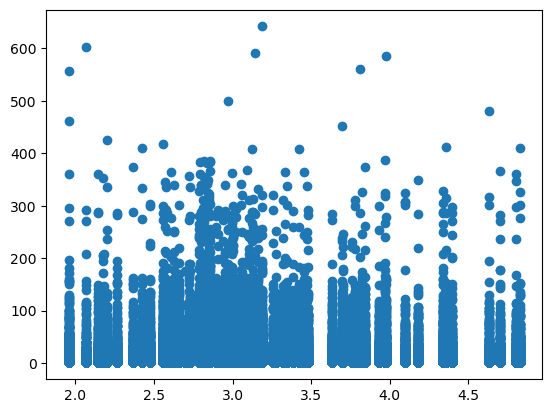

In [111]:
weekly_df
import matplotlib.pyplot as plt
plt.scatter(weekly_df['Avg Gas Price'],weekly_df['Qty'])

In [9]:
# from datetime import datetime
# import calendar



# week_start_dates = weekly_df['Date'].unique()
# week_counter = 1
# week_nums = []
# for start_date in week_start_dates:
#     k = np.datetime64(start_date,'D')
#     q = k + 7
#     print(k,' -> ', q)
#     k_month = k.astype(np.datetime64).astype(object).strftime('%m')
#     q_month = q.astype(np.datetime64).astype(object).strftime('%m')
#     if k_month == q_month:
#         print(' - Month Matched. Setting week number to ', week_counter)
#         week_nums.append((start_date,week_counter))
#         week_counter = week_counter +  1
#         print(' - Updated week number: ',week_counter)
#     else:
#         print(' - Month Not Matched. Calculating difference from end of the month', week_counter)
#         k_year = k.astype(np.datetime64).astype(object).strftime('%Y')
#         last_date_int = calendar.monthrange(int(k_year),int(k_month))[1]
#         last_date = np.datetime64(datetime(year = int(k_year),month = int(k_month) ,day = last_date_int ))
#         diff_k = last_date - k
#         print(' - Difference between start and end of the month: ',diff_k)
#         diff_q = q - last_date
#         print(' - Difference between end and end of the month: ',diff_q)
        
#         if diff_k > diff_q:
#             print(' - Majoirty days falls on last month')
#             print(' - Setting week number: ',week_counter)
#             week_nums.append((start_date,week_counter))
#             print(' - Resetting counter to 1')
#             week_counter = 1
#         else:
#             print(' - Majoirty days falls on next month')
#             print(' - Setting week number 1 ')
#             week_counter = 1
#             print(' - Adding date and week number.')
#             week_nums.append((start_date,week_counter))
#             week_counter = week_counter + 1
            
    

# week_nums
    


<h1>Data Visualization</h1>    

<h2> Relationship between features and target</h2>


Given that our target feature is quantity sold per week, let us visualize the relationship between the predictive features and our target feature. Since this dataset contains products of various types and categories, we will pick only one of the popular item from each of the categories and perform visualization.

In [112]:
#products from various categories
products = [('018200250019','Bud Light 24 Oz Can'),
            ('049000000443','Coke 20 Oz Btl'),
            ('028200003577','Marlboro Red Shorts Box'),
            ('80','Ice Bags'),
            ('876742005135','Deadwood Fat Bottom Betty'),
            ('651357196665','Esco Bars Watermelon Ice')
            ]

#weekly dataframes for wach of the products
products_weekly = []

#create weekly dataframe for each of the products
for code,desc in products:
    prod_weekly_sales_cmb = weekly_df[weekly_df['Scan Code'] == code]
    products_weekly.append(prod_weekly_sales_cmb)

Lets look at the weekly record of Bud Light.

In [113]:
products_weekly[0]

,Date,Scan Code,Description,Department,Qty,POS Cost,POS Retail,Discounts,Month,Week,Year,Avg Temp,Avg Gas Price,Holiday
80,2021-01-01,018200250019,BUD LIGHT 25OZ CAN,BEER,66.0,2.03,2.681707,0.108293,1,53,2021,9.014286,1.9592,1
1414,2021-01-08,018200250019,BUD LIGHT 25OZ CAN,BEER,99.0,2.03,2.674516,0.115484,1,1,2021,6.185714,1.959183,0
2715,2021-01-15,018200250019,BUD LIGHT 25OZ CAN,BEER,96.0,2.03,2.683559,0.106441,1,2,2021,10.0,2.067757,1
4038,2021-01-22,018200250019,BUD LIGHT 25OZ CAN,BEER,87.0,2.03,2.668929,0.121071,1,3,2021,10.471429,2.199186,0
5427,2021-01-29,018200250019,BUD LIGHT 25OZ CAN,BEER,83.0,2.03,2.659167,0.130833,1,4,2021,12.528571,2.176786,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149927,2022-12-02,018200250019,BUD LIGHT 25OZ CAN,BEER,127.0,2.26,3.059697,0.130303,12,48,2022,17.314286,2.809357,0
151418,2022-12-09,018200250019,BUD LIGHT 25OZ CAN,BEER,113.0,2.26,3.055763,0.134237,12,49,2022,14.628571,2.7853,0
152896,2022-12-16,018200250019,BUD LIGHT 25OZ CAN,BEER,101.0,2.26,3.045385,0.144615,12,50,2022,5.271429,2.812514,0
154421,2022-12-23,018200250019,BUD LIGHT 25OZ CAN,BEER,97.0,2.26,3.043846,0.146154,12,51,2022,5.585714,2.6103,2


<h3> Relationship between Week of The Year and Quantity Sold</h3>

For each of items above we will visualize its total sales per week for 2022.

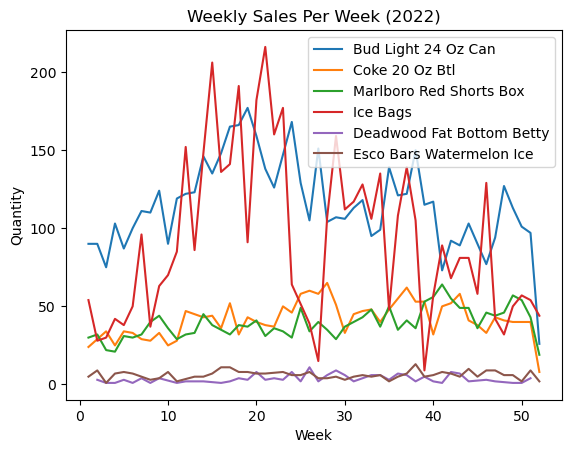

In [114]:
import matplotlib.pyplot as plt

quantities = []
weeks = []

for prod_weekly in products_weekly:
    items_weekly_sales_2021 = prod_weekly[prod_weekly['Year']==2021]
    items_weekly_sales_2022 = prod_weekly[prod_weekly['Year']==2022]
    qty_2021 = items_weekly_sales_2021['Qty']
    qty_2022 = items_weekly_sales_2022['Qty']
    quantities.append(qty_2022)
    week_2021 = list(items_weekly_sales_2021['Week'])
    week_2022 = list(items_weekly_sales_2022['Week'])
    week_2021[0] = 1
    weeks.append(week_2022)
#subplots = []
for i in range(0,6):
    ax = plt.subplot()
    #subplots.append(ax)
    ax.plot(weeks[i], quantities[i], label= products[i][1])
# add a legend
plt.legend()

plt.xlabel('Week')
plt.ylabel('Quantity')
plt.title('Weekly Sales Per Week (2022)')

# display the plot
plt.show()


The above graph shows 

<h3> Relationship between Regular Gas Price and Quantity Sold</h3>

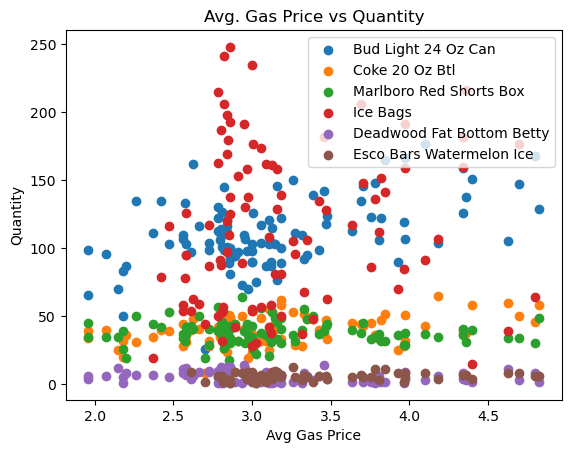

In [115]:
avg_gas_prices = []
quantities = []
for prod_weekly in products_weekly:    
    gas_weekly_sales = prod_weekly.groupby(['Avg Gas Price']).agg({'Qty':'mean'})
    gas_weekly_sales.reset_index(inplace=True)

    avg_gas_prices.append(gas_weekly_sales['Avg Gas Price'])
    quantities.append(gas_weekly_sales['Qty'])

subplots = []
for i in range(0,6):
    ax = plt.subplot()
    #subplots.append(ax)
    ax.scatter(avg_gas_prices[i], quantities[i], label= products[i][1])

plt.xlabel('Avg Gas Price')
plt.ylabel('Quantity')
plt.title('Avg. Gas Price vs Quantity')
plt.legend()
plt.show()


<h3> Relation Ship between Avg Retail Price and Quantity Sold</h3>

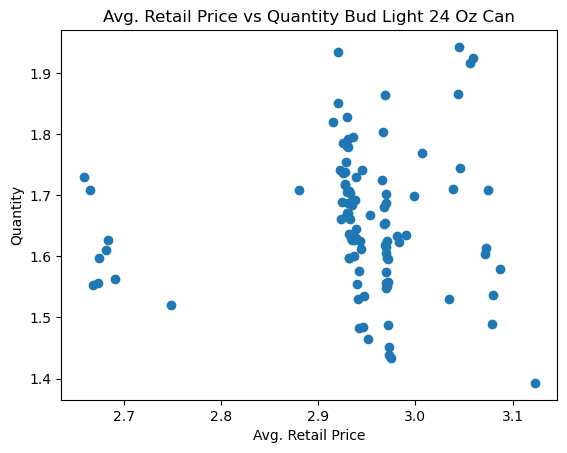

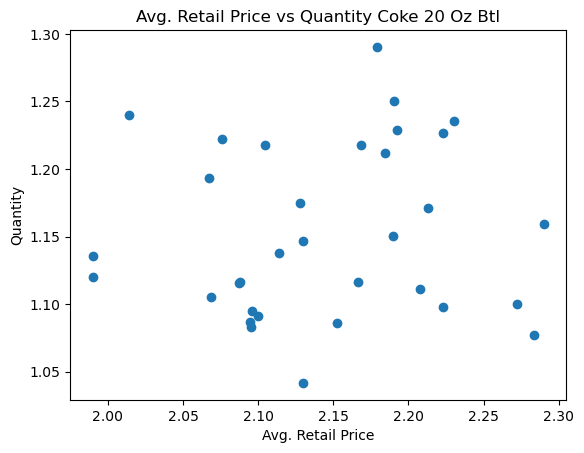

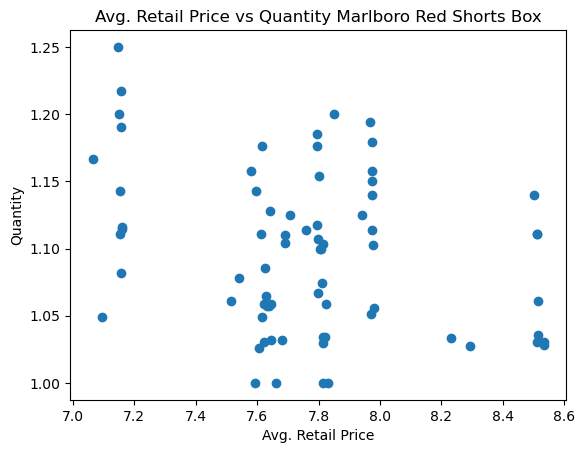

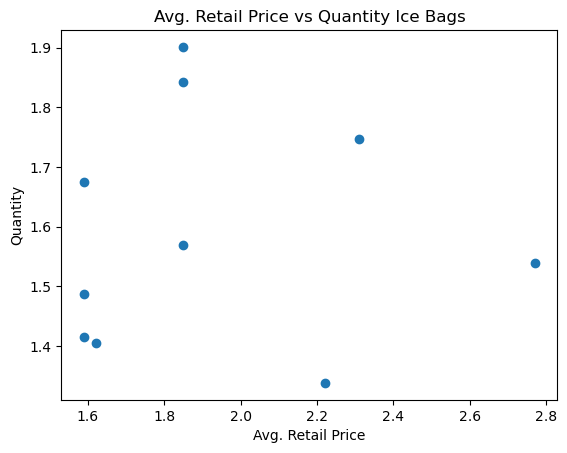

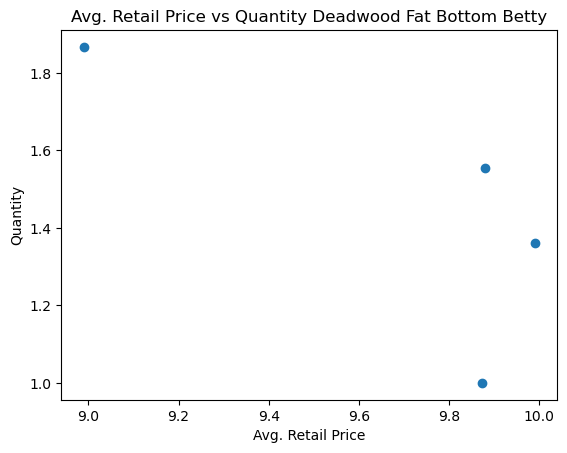

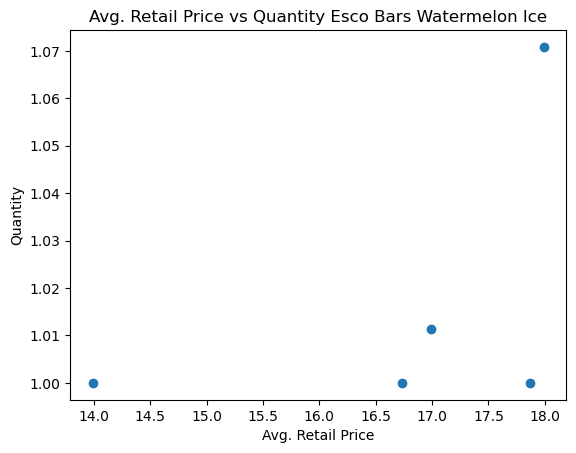

In [14]:
avg_retails = []
quantities = []
for prod_weekly in products_weekly:    
    retail_weekly_sales = prod_weekly.groupby(['POS Retail']).agg({'Qty':'mean'})
    retail_weekly_sales.reset_index(inplace=True)

    avg_retails.append(retail_weekly_sales['POS Retail'])
    quantities.append(retail_weekly_sales['Qty'])

for i in range(0,6):
    ax = plt.subplot()
    #subplots.append(ax)
    ax.scatter(avg_retails[i], quantities[i], label= products[i][1])


    plt.xlabel('Avg. Retail Price')
    plt.ylabel('Quantity')
    plt.title('Avg. Retail Price vs Quantity '+products[i][1])
    plt.show()

<h3> Relation Ship between Regular Temperature and Quantity Sold</h3>


In [15]:
# temp_weekly_sales = items_weekly_sales_cmb.groupby(['Avg Temp']).agg({'Qty':'sum'})
# temp_weekly_sales.reset_index(inplace=True)
# x = temp_weekly_sales['Avg Temp']
# y = temp_weekly_sales['Qty']
# plt.xlabel('Avg. Weekly Temp (Celcius)')
# plt.ylabel('Quantity')
# plt.title('Avg. Weekly Temp (Celcius) vs Quantity')
# plt.plot(x,y)
# plt.show()

<h1>Department Wise Data</h1>

The department column in the dataset is a nominal value representing the group a product belongs to. 

                        Qty
Department                 
LOTTO SCRATCH OFF  200385.0
Cigar              191082.0
BEER               173967.0
SODA               124984.0
GAS                 72788.0
TAXABLE GROCER      50722.0
NOVELTY             49410.0
Cigarettes          42991.0
SNACKS              41883.0
LOTTO ONLINE        31135.0
ICE BAG             28110.0
CIG CHEAP           26165.0
IMP CIGAR           23738.0
NON TAX             23649.0
MARLBORO            23444.0
CANDY               20673.0
TOBACCO             16578.0
ECigs               13142.0
Miscs                9970.0
WINE                 8355.0
CBD                  6351.0
CIGARET CT           3178.0
Kratoms              2505.0
NEW ITEMS              79.0
GAS PUMP #1            12.0
HOUSE USE               1.0


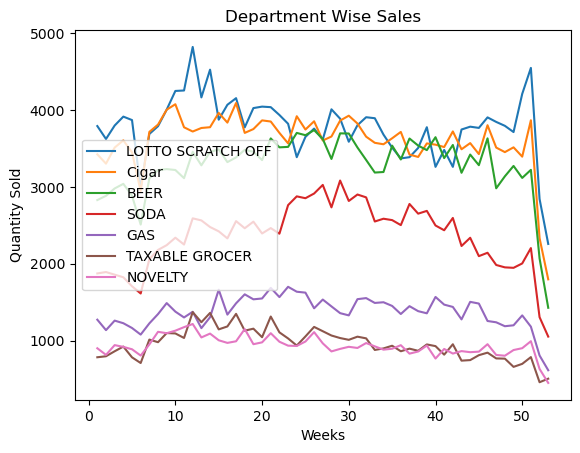

In [116]:
import matplotlib.pyplot as plt
departments = list(weekly_df['Department'].unique())

department_total = weekly_df.groupby(['Department','Week']).agg({'Qty':'sum'})
department_total.reset_index(inplace=True)
total_sales = department_total.groupby(['Department']).agg({'Qty':'sum'})
sorted_list = total_sales.sort_values(by = ['Qty'],ascending = False)
print(sorted_list)

viz_depts = sorted_list[0:7]
viz_depts.reset_index(inplace = True)
visualization_depts = viz_depts['Department']


for department in visualization_depts:
    dept_weekly = department_total[department_total['Department']== department]
    dept_weekly_qty = list(dept_weekly['Qty'])
    dept_weeks = list(dept_weekly['Week'])
    ax = plt.subplot()
    ax.plot(dept_weeks, dept_weekly_qty, label= department)

    department_df = []
for department in departments:
    dept_df = weekly_df[weekly_df['Department']==department]
    
    
    
    
plt.xlabel('Weeks')
plt.ylabel('Quantity Sold')
plt.title('Department Wise Sales')
plt.legend()
plt.show()

<H1>Model Creation</H1>

In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor 
from sklearn import metrics, svm
# # Split columns into features and target
# X = products_weekly[0][['Month','Week','Scan Code', 'POS Retail','POS Cost', 'Discounts','Avg Temp','Avg Gas Price']]
# y = products_weekly[0]['Qty']

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [18]:
# model = GaussianNB()
# model.fit(X_train, y_train)
# pred = model.predict(X_test)

In [19]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)
# y_pred = svr.predict(X_test)
# score = svr.score(X_test, y_test)
# print("Model score:", score)
#print(y_pred)

In [20]:
# Train the KNN model 


# params = {"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 14, 15, 17, 19, 21, 23, 25, 27, 39],
#           "weights": ["uniform", "distance"],
#           "metric": ["euclidean", "manhattan"]}
# knn = KNeighborsRegressor()
# grid_search = GridSearchCV(knn, params, cv=11, n_jobs=-1)
# grid_search.fit(X, y)
# best_param = grid_search.best_params_
# print(best_param)
# knn = KNeighborsRegressor(metric = best_param['metric'],n_neighbors = best_param['n_neighbors'],weights = best_param['weights'])
# knn.fit(X_train,y_train)
# pred = knn.predict(X_test)


In [21]:
# pred = list(pred)
# act = list(y_test)
# prd = list(X_test['Scan Code'])
# report = open('report.csv','w')
# for i in range(0,len(pred)):
#     print(prd[i],act[i],' -> ',pred[i])
#     report.write(str(prd[i]) + ','+ str(act[i])+','+str(pred[i])+'\n')
    
# report.close()

In [118]:
weekly_df

,Date,Scan Code,Description,Department,Qty,POS Cost,POS Retail,Discounts,Month,Week,Year,Avg Temp,Avg Gas Price,Holiday
0,2021-01-01,008660000187,Zogzag Cone 11/4 A,NOVELTY,6.0,0.91,2.4900,0.0000,1,53,2021,9.014286,1.9592,1
1,2021-01-01,008660007384,Zig Zag Hemp 1.25,NOVELTY,2.0,0.83,1.9900,0.0000,1,53,2021,9.014286,1.9592,1
2,2021-01-01,010700000088,jrancher fruitchew pop 10,CANDY,13.0,0.36,0.4600,0.0000,1,53,2021,9.014286,1.9592,1
3,2021-01-01,010700060808,HEATH BAR,CANDY,1.0,0.59,1.2900,0.0000,1,53,2021,9.014286,1.9592,1
4,2021-01-01,010700804228,ZERO,CANDY,2.0,0.82,1.2900,0.0000,1,53,2021,9.014286,1.9592,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156910,2022-12-30,894135001182,Good Stuff Lt 6 Oz,TOBACCO,1.0,11.99,16.9900,0.0000,12,52,2022,14.95,2.697529,1
156911,2022-12-30,895216001060,FOUR LOCO PEACH 24OZ CAN,BEER,5.0,2.53,3.4475,0.1425,12,52,2022,14.95,2.697529,1
156912,2022-12-30,898999010229,VITA COCO WATER,SODA,1.0,2.08,3.5900,0.0000,12,52,2022,14.95,2.697529,1
156913,2022-12-30,9097202112052,Cannabeast Doobie Cookies,CBD,1.0,6.00,15.9900,0.0000,12,52,2022,14.95,2.697529,1


In [134]:
def min_max_normalization(df,feature_name):
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    print(max_value)
    df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df


In [170]:
dept_model = []
for department in departments:
    dept_products = weekly_df[weekly_df['Department']==department]
    print('prediction for department: ',department)
    dept_products.drop(columns=['Description','Department'])
    #dept_products.to_csv(department+'.csv',index=False)
    min_max_normalization(dept_products,'Qty')
    X = dept_products[['Year','Month','Scan Code','Week', 'POS Retail','POS Cost', 'Discounts','Avg Temp','Holiday']]
    y = dept_products['Qty']
    if(len(X)>10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        params = {"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 14, 15, 17, 19, 21, 23, 25, 27, 39],
              "weights": ["uniform", "distance"],
              "metric": ["euclidean", "manhattan"]}



        knn = KNeighborsRegressor()
        grid_search = GridSearchCV(knn, params, cv=11, n_jobs=-1)
        grid_search.fit(X, y)
        best_params = grid_search.best_params_
        print(best_params)
        knn = KNeighborsRegressor(metric = best_params['metric'],n_neighbors = best_params['n_neighbors'],weights = best_params['weights'])
        knn.fit(X_train,y_train)
        pred = knn.predict(X_test)

        pred = list(pred)
        act = list(y_test)
        report = open('data/csv/computed/'+department.lower()+'_report.csv','w')
        dept_model.append((department,knn))

        for i in range(0,len(pred)):
            #print(X_test.iloc[i]['Scan Code'])
            #print(X_test[''],act[i],' -> ',pred[i])
            report.write(str(X_test.iloc[i]['Week'])+','+ str(X_test.iloc[i]['Year'])+','+ str(act[i])+','+str(pred[i])+'\n')
        print('---------------------------- End for a department -----------------------------')


prediction for department:  NOVELTY
92.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  CANDY
33.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 39, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  SODA
73.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  NON TAX
43.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  TAXABLE GROCER
150.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  Cigarettes
123.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  CIGARET CT
13.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}
---------------------------- End for a department -----------------------------
prediction for department:  SNACKS
35.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 39, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  Miscs
41.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  BEER
177.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  Cigar
209.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  MARLBORO
64.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
---------------------------- End for a department -----------------------------
prediction for department:  TOBACCO
62.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 39, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  IMP CIGAR
52.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 39, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  WINE
22.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 39, 'weights': 'uniform'}
---------------------------- End for a department -----------------------------
prediction for department:  CIG CHEAP
66.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 39, 'weights': 'uniform'}
---------------------------- End for a department -----------------------------
prediction for department:  GAS PUMP #1
4.0
prediction for department:  GAS
452.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'uniform'}
---------------------------- End for a department -----------------------------
prediction for department:  LOTTO ONLINE
642.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'euclidean', 'n_neighbors': 39, 'weights': 'uniform'}
---------------------------- End for a department -----------------------------
prediction for department:  ICE BAG
480.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  NEW ITEMS
6.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
---------------------------- End for a department -----------------------------
prediction for department:  LOTTO SCRATCH OFF
360.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  Kratoms 
24.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  ECigs
13.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'manhattan', 'n_neighbors': 39, 'weights': 'distance'}
---------------------------- End for a department -----------------------------
prediction for department:  CBD
51.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
---------------------------- End for a department -----------------------------
prediction for department:  HOUSE USE
1.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [139]:
from utils.utils import get_2023_test

In [140]:
test_set = get_2023_test()

Before removing nan scan codes :  (146274, 15)
After removing NaN scan codes :  (137204, 15)
After removing numm zero costs :  (136867, 13)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [153]:
test_set.shape

(25125, 13)

In [156]:
first_week = test_set[test_set['Week']==52]
first_week.drop(first_week[first_week['Qty'] < 0].index,axis = 0,inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [159]:
min_max_normalization(first_week,'Qty')

7.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Scan Code,Description,Department,Qty,POS Cost,POS Retail,Discounts,Month,Week,Year,Avg Temp,Holiday
0,2023-01-01,008660000026,ZIG-ZAG PAPERS- 1 1/4,Cigar,0.032258,1.50,2.79,0.0,1,52,2023,14.914286,1
1,2023-01-01,008660000071,ZIG-ZAG PAPERS KING,Cigar,0.032258,1.50,2.99,0.0,1,52,2023,14.914286,1
2,2023-01-01,008660007384,Zig Zag Hemp 1.25,NOVELTY,0.193548,0.87,1.99,0.0,1,52,2023,14.914286,1
3,2023-01-01,009060000036,rip rolls blue respberry 1.4oz,CANDY,0.032258,0.50,1.69,0.0,1,52,2023,14.914286,1
4,2023-01-01,009800000524,KINDER JOY TREAT & TOY,CANDY,0.032258,1.67,2.79,0.0,1,52,2023,14.914286,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,2023-01-01,895301001449,HIGH FIVE ORANGE DRINK,SODA,0.032258,0.67,1.19,0.0,1,52,2023,14.914286,1
1525,2023-01-01,898999010229,VITA COCO WATER,SODA,0.032258,2.08,3.59,0.0,1,52,2023,14.914286,1
1526,2023-01-01,898999012698,vita coco pulp juice,SODA,0.032258,1.31,2.79,0.0,1,52,2023,14.914286,1
1527,2023-01-01,9555755800043,Royal Honey,NOVELTY,0.112903,3.50,8.99,0.0,1,52,2023,14.914286,1


In [173]:
departments = first_week['Department'].unique()

5.333333333333333


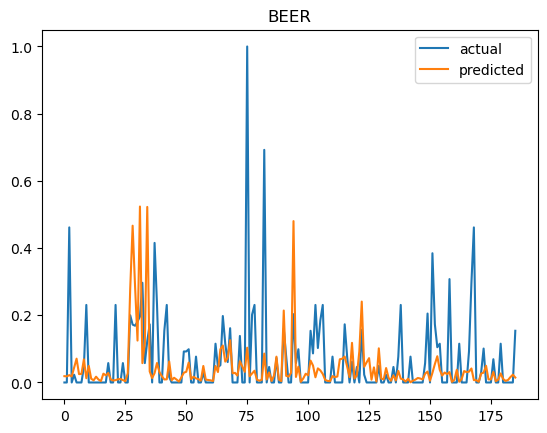

---------------------------- End for BEER -----------------------------


In [177]:
dept_preds = []
for department in departments:
    dept_products = first_week[first_week['Department']==department]
    min_max_normalization(dept_products,'Qty')
    X = dept_products[['Year','Month','Scan Code','Week', 'POS Retail','POS Cost', 'Discounts','Avg Temp','Holiday']]
    y = dept_products['Qty']
    predicted = []
    
    for dept,model in dept_model:
        if department == dept:
            predicted = model.predict(X)
            predicted = list(predicted)
            dept_preds.append((department,predicted))
            act = list(y)
            #prd = list(X['Scan Code'])
            my_list = [x for x in range(len(predicted))] 

            report = open('data/csv/computed/2023W1'+department.lower()+'_report.csv','w')
            ax = plt.subplot()
            ax.plot(my_list, act, label= 'actual')
            ax.plot(my_list, predicted, label= 'predicted')
            plt.title(department)
            plt.legend()
            plt.show()
        

            for i in range(0,len(predicted)):
                #print(X.iloc[i]['Scan Code'])
                #print(X_test[''],act[i],' -> ',pred[i])
                report.write(str(X.iloc[i]['Week'])+','+ str(X.iloc[i]['Year'])+','+str(X.iloc[i]['Discounts'])+','+str(X.iloc[i]['Avg Temp'])+','+ str(act[i])+','+str(predicted[i])+'\n')
            print('---------------------------- End for',department, '-----------------------------')

        

In [169]:
weekly_df

,Date,Scan Code,Description,Department,Qty,POS Cost,POS Retail,Discounts,Month,Week,Year,Avg Temp,Avg Gas Price,Holiday
0,2021-01-01,008660000187,Zogzag Cone 11/4 A,NOVELTY,6.0,0.91,2.4900,0.0000,1,53,2021,9.014286,1.9592,1
1,2021-01-01,008660007384,Zig Zag Hemp 1.25,NOVELTY,2.0,0.83,1.9900,0.0000,1,53,2021,9.014286,1.9592,1
2,2021-01-01,010700000088,jrancher fruitchew pop 10,CANDY,13.0,0.36,0.4600,0.0000,1,53,2021,9.014286,1.9592,1
3,2021-01-01,010700060808,HEATH BAR,CANDY,1.0,0.59,1.2900,0.0000,1,53,2021,9.014286,1.9592,1
4,2021-01-01,010700804228,ZERO,CANDY,2.0,0.82,1.2900,0.0000,1,53,2021,9.014286,1.9592,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156910,2022-12-30,894135001182,Good Stuff Lt 6 Oz,TOBACCO,1.0,11.99,16.9900,0.0000,12,52,2022,14.95,2.697529,1
156911,2022-12-30,895216001060,FOUR LOCO PEACH 24OZ CAN,BEER,5.0,2.53,3.4475,0.1425,12,52,2022,14.95,2.697529,1
156912,2022-12-30,898999010229,VITA COCO WATER,SODA,1.0,2.08,3.5900,0.0000,12,52,2022,14.95,2.697529,1
156913,2022-12-30,9097202112052,Cannabeast Doobie Cookies,CBD,1.0,6.00,15.9900,0.0000,12,52,2022,14.95,2.697529,1


<h1>PCA</h1>

In [178]:
from sklearn.decomposition import PCA

In [183]:
#dummy dataset
department = 'BEER'
soda_df = weekly_df[weekly_df['Department'] == department]
min_max_normalization(soda_df,'Qty')
X_train = soda_df[['Year','Month','Week','Scan Code', 'POS Retail','POS Cost', 'Discounts','Avg Temp','Holiday']]
y_train = soda_df['Qty']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
test_soda_df = test_set[test_set['Department']== department]
first_week = test_soda_df[test_soda_df['Week'] == 52]
min_max_normalization(first_week,'Qty')
X_test = first_week[['Year','Month','Week','Scan Code', 'POS Retail','POS Cost', 'Discounts','Avg Temp','Holiday']]
y_test = first_week['Qty']


177.0
5.333333333333333


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [184]:
params = {"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 14, 15, 17, 19, 21, 23, 25, 27, 39],
          "weights": ["uniform", "distance"],
          "metric": ["euclidean", "manhattan"]}
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, params, cv=11, n_jobs=-1)
grid_search.fit(X_test, y_test)
best_params = grid_search.best_params_
print(best_params)
knn = KNeighborsRegressor(metric = best_params['metric'],n_neighbors = best_params['n_neighbors'],weights = best_params['weights'])


{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


[1.]
[1.00000000e+00 4.68686696e-21]
[1.00000000e+00 4.68686694e-21 1.49354323e-21]
[1.00000000e+00 4.68686696e-21 1.49354323e-21 1.35979029e-21]
[1.00000000e+00 4.68686694e-21 1.49354323e-21 1.35979029e-21
 2.37247233e-23]
[1.00000000e+00 4.68686695e-21 1.49354323e-21 1.35979029e-21
 2.37248878e-23 1.27684414e-23]
[1.00000000e+00 4.68686694e-21 1.49354323e-21 1.35979029e-21
 2.37248418e-23 1.27684410e-23 5.33517424e-24]
[1.00000000e+00 4.68686695e-21 1.49354323e-21 1.35979029e-21
 2.37249165e-23 1.27684416e-23 5.33517732e-24 4.87773695e-24]
[1.00000000e+00 4.68686695e-21 1.49354323e-21 1.35979029e-21
 2.37249165e-23 1.27684416e-23 5.33517732e-24 4.87773695e-24
 8.89673119e-25]


Text(0, 0.5, 'Model Prediction Accuracy')

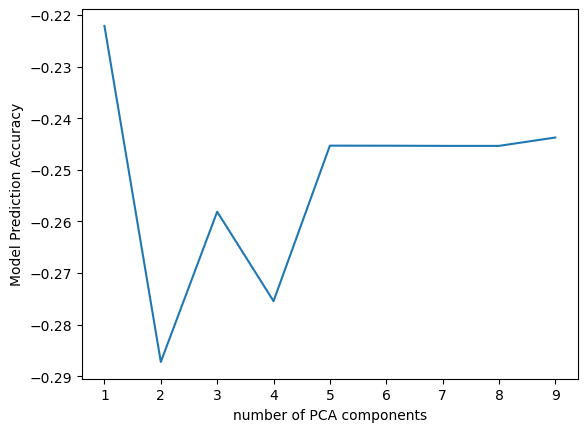

In [185]:
import matplotlib.pyplot as plt
import pylab as py
pca = PCA(n_components=11)
accuracy = []
n_comp = range(1,10)
for i in n_comp:
    pca = PCA(n_components = i)
    pca.fit(X_train)
    print(pca.explained_variance_ratio_)
    tX_train = pca.transform(X_train)
    tX_test = pca.transform(X_test)
    knn.fit(tX_train,y_train)
    test_score = knn.score(tX_test,y_test) 
    accuracy.append(test_score)
py.plot(n_comp,accuracy)
py.xlabel('number of PCA components')
py.ylabel('Model Prediction Accuracy')

In [186]:
before_pca = []
for dept,preds in dept_preds:
    if dept == 'BEER':
        before_pca = preds 


In [187]:
print('before pca: ',len(before_pca))

before pca:  186


In [188]:
from sklearn.decomposition import PCA

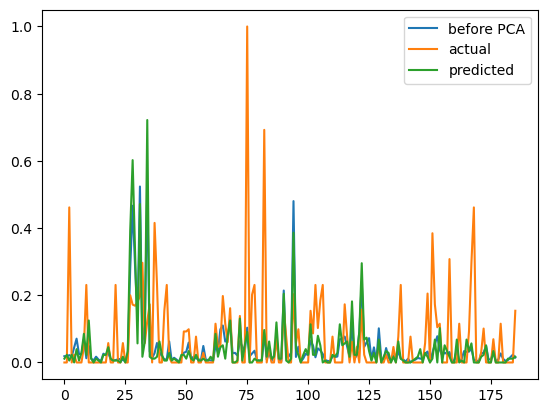

In [189]:
pca = PCA(n_components = 3)
pca.fit(X_train)
tX_train = pca.transform(X_train)
tX_test = pca.transform(X_test)
knn.fit(tX_train,y_train)
predicted = knn.predict(tX_test)
my_list = [x for x in range(len(predicted))] 
ax = plt.subplot()
ax.plot(my_list, before_pca, label= 'before PCA')
ax.plot(my_list, y_test, label= 'actual')
ax.plot(my_list, predicted, label= 'predicted')
plt.legend()
plt.show()

In [190]:
def range_plot(my_list, before_pca, predicted, start,end):
    ax = plt.subplot()
    ax.plot(my_list[start:end], before_pca[start:end], label= 'before PCA',color = 'red')
    ax.plot(my_list[start:end], y_test[start:end], label= 'actual',color='blue')
    ax.plot(my_list[start:end], predicted[start:end], label= 'predicted',color='green')
    plt.legend()
    plt.show()
    

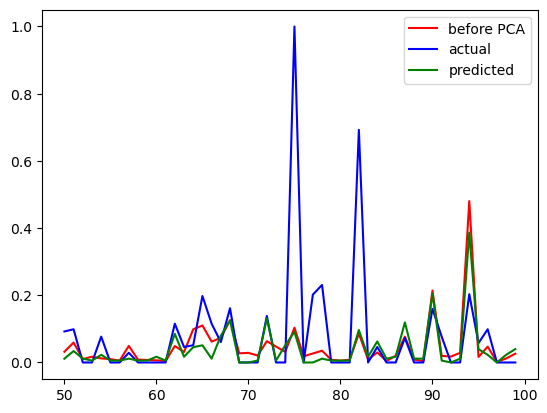

In [191]:
range_plot(my_list, before_pca, predicted,50,100)

<h1>ANN</h1>

In [40]:
from sklearn.neural_network import MLPRegressor
# Create a parameter grid
param_grid = {'hidden_layer_sizes': [(10,),(9,),(8,),(7,),(6,),(5,),(4,),(3,),(2,),(1,)],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001,0.001,0.01,0.0005,0.005,0.05, 0.0002,0.002,0.02],
              'learning_rate': ['constant','adaptive']}
model = MLPRegressor() 
clf = GridSearchCV(model, param_grid, cv=5, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)
print("Best Parameters:", clf.best_params_)
# demand_model.fit(X_train, y_train)
# y_pred = demand_model.predict(X_test)


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=constant, 

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(7,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(7,), learning_rate=constant, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(7,), learning_rate=constant, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(7,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(7,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(7,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=constant, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(7,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(7,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.00

/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jigme/opt/anacond

[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(9,), learning_rate=constant, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(8,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(7,), learning_rate=constant, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(7,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_

/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(9,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(8,), learning_rate=constant, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(7,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(6,), learning_rate=constant, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(6,), learning_rate=adaptive, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(5,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(5,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_si

[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(2,), learning_rate=constant, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(2,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(2,), learning_rate=adaptive, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(1,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_s

[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(2,), learning_rate=constant, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(2,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(1,), learning_rate=constant, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(1,), learning_rate=adaptive, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(1,), learning_rate=adaptive, solver=adam; total time=   1.1s
[CV] END activation=tanh, alpha=0.0002, hidden_la

[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(5,), learning_rate=adaptive, solver=adam; total time=   0.8s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(2,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_siz

/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(5,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam; total time=   0.7s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam; total time=   1.0s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam; total time=   0.7s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(2,), learning_rate=constant, solver=adam; total time=   0.9s
[CV] END activation=tanh, alpha=0.05, hidden_layer_

[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(6,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(6,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(5,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(5,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam; total time=   0.9s
[CV] END activation=tanh, alpha=0.05, hidden_layer_siz

[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(6,), learning_rate=constant, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(6,), learning_rate=adaptive, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(6,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(5,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(5,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.05, hidden_layer_si

/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jigme/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jigme/opt/anacond

Best Parameters: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (9,), 'learning_rate': 'constant', 'solver': 'adam'}


In [41]:
print(clf.best_params_)

{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (9,), 'learning_rate': 'constant', 'solver': 'adam'}


[1.]
[1.00000000e+00 4.68686697e-21]
[1.00000000e+00 4.68686696e-21 1.49354323e-21]
[1.00000000e+00 4.68686694e-21 1.49354323e-21 1.35979029e-21]
[1.00000000e+00 4.68686690e-21 1.49354323e-21 1.35979029e-21
 2.37247588e-23]
[1.00000000e+00 4.68686693e-21 1.49354323e-21 1.35979029e-21
 2.37249734e-23 1.27684416e-23]
[1.00000000e+00 4.68686694e-21 1.49354323e-21 1.35979029e-21
 2.37247360e-23 1.27684419e-23 5.33517937e-24]
[1.00000000e+00 4.68686695e-21 1.49354323e-21 1.35979029e-21
 2.37249165e-23 1.27684416e-23 5.33517732e-24 4.87773695e-24]
[1.00000000e+00 4.68686695e-21 1.49354323e-21 1.35979029e-21
 2.37249165e-23 1.27684416e-23 5.33517732e-24 4.87773695e-24
 8.89673119e-25]


Text(0, 0.5, 'Model Prediction Accuracy')

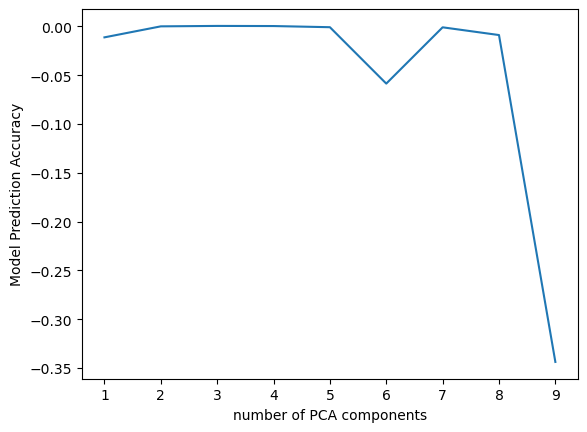

In [86]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
import pylab as py
model = MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(9,), learning_rate='constant', solver='adam') 
pca = PCA(n_components=10)
accuracy = []
n_comp = range(1,10)
for i in n_comp:
    pca = PCA(n_components = i)
    pca.fit(X_train)
    print(pca.explained_variance_ratio_)
    tX_train = pca.transform(X_train)
    tX_test = pca.transform(X_test)
    model.fit(tX_train,y_train)
    test_score = model.score(tX_test,y_test) 
    accuracy.append(test_score)
py.plot(n_comp,accuracy)
py.xlabel('number of PCA components')
py.ylabel('Model Prediction Accuracy')

In [89]:
from sklearn.neural_network import MLPRegressor
pca = PCA(n_components = 2)
pca.fit(X_train)
tX_train = pca.transform(X_train)
tX_test = pca.transform(X_test)
model.fit(tX_train,y_train)
y_pred = model.predict(tX_test)

In [92]:
y_pred


array([0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010018,
       0.83010018, 0.83010018, 0.83010018, 0.83010018, 0.83010

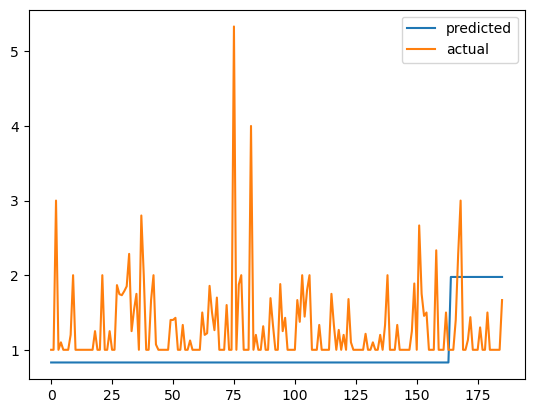

In [91]:
ax = plt.subplot()
my_list = [x for x in range(0,len(y_pred))]
ax.plot(my_list,y_pred,label = 'predicted')
ax.plot(my_list,y_test,label = 'actual')
plt.legend()
plt.show()

In [46]:
model = MLPRegressor(activation='tanh', alpha=0.0005, hidden_layer_sizes=(8,2,1), learning_rate='constant', solver='sgd')


In [47]:
X_test

,Year,Month,Week,Scan Code,POS Retail,POS Cost,Discounts,Avg Temp,Holiday
53,2023,1,52,018200000089,4.190000,2.53,0.000000,14.914286,1
54,2023,1,52,018200000164,8.990000,6.53,0.000000,14.914286,1
55,2023,1,52,018200000188,1.990000,0.67,0.000000,14.914286,1
56,2023,1,52,018200000638,8.990000,6.80,0.000000,14.914286,1
57,2023,1,52,018200000706,3.190000,2.41,0.000000,14.914286,1
...,...,...,...,...,...,...,...,...,...
1412,2023,1,52,849806003002,3.590000,2.53,0.000000,14.914286,1
1413,2023,1,52,849806004726,3.590000,2.53,0.000000,14.914286,1
1520,2023,1,52,895216001046,3.400000,2.53,0.190000,14.914286,1
1521,2023,1,52,895216001060,3.495000,2.53,0.095000,14.914286,1


In [93]:
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [94]:
pred

array([1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076751,
       1.24076751, 1.24076751, 1.24076751, 1.24076751, 1.24076

<h1> Support Vector Regressor </h1>

In [50]:
from sklearn.svm import SVR
model = SVR()
params = {'C': [0.1, 0.01, 0.001,], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']}
grid_svr = GridSearchCV(SVR(), params, cv=3, scoring='neg_mean_squared_error', n_jobs= 2)
grid_svr.fit(X_train, y_train)
print(grid_svr.best_params_)

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate=constant, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate=adaptive, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(7,), learning_rate=constant, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(7,), learning_rate=adaptive, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(7,), learning_rate=adaptive, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(6,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_layer

{'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}


In [61]:
print(grid_svr.best_params_)

{'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}


In [62]:
model = SVR(C = 0.001, gamma =  0.0000000000001, kernel = 'rbf')

In [63]:
model.fit(X_train,y_train)

SVR(C=0.001, gamma=1e-13)

In [53]:
y_train.shape

(18818,)

In [54]:
X_train.shape

(18818, 9)

In [71]:
pred = model.predict(X_test)

In [65]:
print(model.dual_coef_.shape)

(1, 13922)


In [68]:
my_list = [x for x in range(0,len(y_test))]

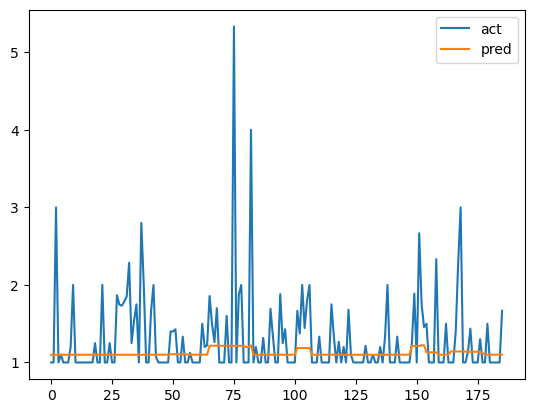

In [72]:
ax = plt.subplot()
ax.plot(my_list,y_test,label = 'act')
ax.plot(my_list,pred,label = 'pred')
plt.legend()

[1.]
[1.00000000e+00 4.68686694e-21]
[1.00000000e+00 4.68686696e-21 1.49354323e-21]
[1.00000000e+00 4.68686694e-21 1.49354323e-21 1.35979029e-21]
[1.00000000e+00 4.68686695e-21 1.49354323e-21 1.35979029e-21
 2.37249199e-23]
[1.00000000e+00 4.68686694e-21 1.49354323e-21 1.35979029e-21
 2.37248837e-23 1.27684416e-23]
[1.00000000e+00 4.68686701e-21 1.49354323e-21 1.35979029e-21
 2.37248035e-23 1.27684416e-23 5.33517665e-24]
[1.00000000e+00 4.68686695e-21 1.49354323e-21 1.35979029e-21
 2.37249165e-23 1.27684416e-23 5.33517732e-24 4.87773695e-24]
[1.00000000e+00 4.68686695e-21 1.49354323e-21 1.35979029e-21
 2.37249165e-23 1.27684416e-23 5.33517732e-24 4.87773695e-24
 8.89673119e-25]


Text(0, 0.5, 'Model Prediction Accuracy')

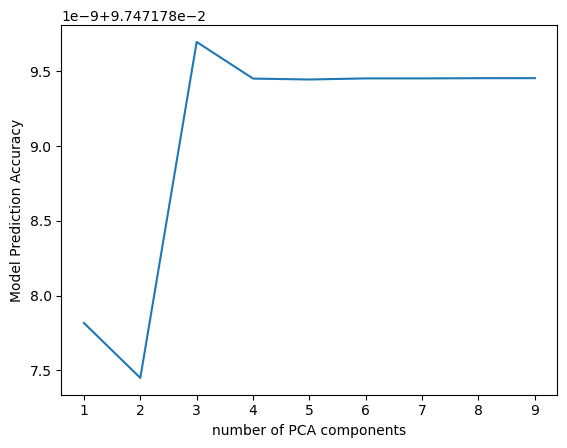

In [59]:
pca = PCA(n_components=10)
accuracy = []
n_comp = range(1,10)
for i in n_comp:
    pca = PCA(n_components = i)
    pca.fit(X_train)
    print(pca.explained_variance_ratio_)
    tX_train = pca.transform(X_train)
    tX_test = pca.transform(X_test)
    model.fit(tX_train,y_train)
    test_score = model.score(tX_test,y_test) 
    accuracy.append(test_score)
py.plot(n_comp,accuracy)
py.xlabel('number of PCA components')
py.ylabel('Model Prediction Accuracy')

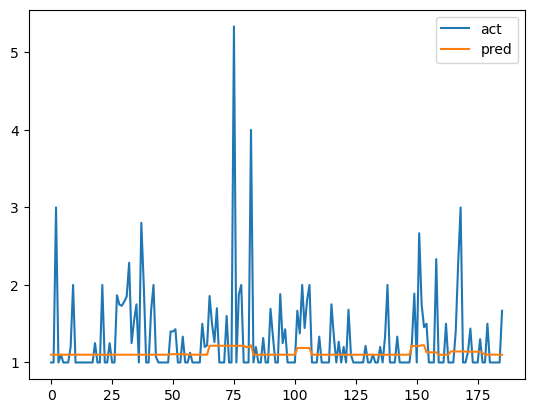

In [81]:
pca = PCA(n_components=3)
pca.fit(X_train)
tX_train = pca.transform(X_train)
tX_test = pca.transform(X_test)
model.fit(tX_train,y_train)
pred = model.predict(tX_test)

ax = plt.subplot()
ax.plot(my_list,y_test,label = 'act')
ax.plot(my_list,pred,label = 'pred')
plt.legend()

In [74]:
print(model.score)
print(model.support_vectors_)
print(model.dual_coef_.shape)
print(X_train.shape)

<bound method RegressorMixin.score of SVR(C=0.001, gamma=1e-13)>
[[-1.08369993e+11 -2.25720450e+01]
 [-1.08369992e+11 -2.26735231e+01]
 [-1.08369992e+11 -2.25514151e+01]
 ...
 [ 7.23236010e+11 -2.46342891e+01]
 [ 7.23236012e+11 -2.46342891e+01]
 [ 7.68646008e+11 -2.46268129e+01]]
(1, 13939)
(18818, 9)


In [76]:
from scipy.stats import pearsonr

In [82]:
x = weekly_df['Discounts']
y = weekly_df['POS Retail']
corr, p_val = pearsonr(x, y)
print(corr)

0.03307939145919565


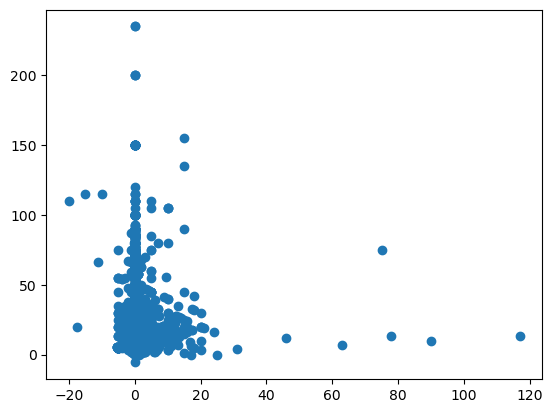

In [83]:
plt.scatter(x,y)

In [80]:
negative = weekly_df[weekly_df['POS Retail'] < 0 ]
negative

,Date,Scan Code,Description,Department,Qty,POS Cost,POS Retail,Discounts,Month,Week,Year,Avg Temp,Avg Gas Price,Holiday
156516,2022-12-30,2235,GAS PUMP #1,GAS,-0.333333,0.0,-5.663333,0.0,12,52,2022,14.95,2.697529,1


In [85]:
negative = weekly_df[weekly_df['Discounts'] < 0 ]
negative

,Date,Scan Code,Description,Department,Qty,POS Cost,POS Retail,Discounts,Month,Week,Year,Avg Temp,Avg Gas Price,Holiday
1895,2021-01-08,070330622401,BIC LIGHTER FAVORITE W141,Miscs,1.047619,0.70,1.856667,-0.006667,1,1,2021,6.185714,1.959183,0
2766,2021-01-15,024291290681,TPASTE TBRUSH KIT PEG,TAXABLE GROCER,1.000000,1.42,2.990000,-0.400000,1,2,2021,10.0,2.067757,1
2826,2021-01-15,027200018512,PALL MALL BOX RED CRTN,CIGARET CT,1.000000,63.49,66.990000,-2.090000,1,2,2021,10.0,2.067757,1
3244,2021-01-15,071990000080,COORLT 6-12OZ CAN,BEER,1.000000,5.85,7.890000,-0.100000,1,2,2021,10.0,2.067757,1
3262,2021-01-15,072470000507,krispy kream glzd cinnamon bun,SNACKS,1.000000,1.29,1.990000,-0.140000,1,2,2021,10.0,2.067757,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150731,2022-12-02,222556677509,bomb bar og kush hybrid 3.5g,CBD,1.000000,18.00,45.990000,-1.000000,12,48,2022,17.314286,2.809357,0
153418,2022-12-16,071610496682,DUTCH BERRY FUSION,Cigar,2.090909,0.66,1.194545,-0.204545,12,50,2022,5.271429,2.812514,0
155253,2022-12-23,218,WINTER CAP 4.99,NOVELTY,1.000000,2.50,5.490000,-0.500000,12,51,2022,5.585714,2.6103,2
156253,2022-12-30,049000028904,COKE 12PK CAN,SODA,1.111111,5.63,8.190000,-0.600000,12,52,2022,14.95,2.697529,1
